# Project Overview

A tree-based machine learning pipeline (XGBoost) to differentiate lower grade gliomas and glioblastoma from The Cancger Imaging Archive (TCIA) data

# Loading Packages

In [2]:
from numpy import loadtxt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from itertools import product

# Loading Data

In [3]:
dataset = 'the_cancer_imaging_archive_dataset.xlsx'
target_col_num = 0 

In [4]:
df = pd.read_excel(dataset)
df[df.columns[target_col_num]].str.strip() # strip spaces in target column
target_col_name = df.columns[target_col_num] # save target column name 
#print(target_col_name)
df.head()

,Study,Age (years at diagnosis),Gender,Survival (months),Vital status (1=dead),Karnofsky Performance Score,Mutation Count,Percent aneuploidy,IDH status,1p/19q codeletion,...,TemporalLobe,Thalamus,Cerebellum,Caudate,Putamen,VOLUME_ET (1mm3voxel),VOLUME_NET (1mm3voxel),VOLUME_ED (1mm3voxel),VOLUME_TC (1mm3voxel),VOLUME_WT (1mm3voxel)
0,Glioblastoma multiforme,50,male,4.731106,1,100.0,52.0,0.147988,WT,non-codel,...,20.696400,0.000000,0.000000,0.000000,0.000000,12695,1464,64803,14159,78962
1,Glioblastoma multiforme,56,female,18.333034,1,80.0,NaN,0.239055,WT,non-codel,...,53.870900,0.000000,0.000000,0.000000,0.847907,1662,384,36268,2046,38314
2,Glioblastoma multiforme,61,female,10.579278,1,80.0,NaN,0.159619,WT,non-codel,...,14.742100,0.164541,0.042307,0.021401,0.032000,4362,4349,15723,8711,24434
3,Glioblastoma multiforme,18,female,20.698587,1,80.0,NaN,0.613150,WT,non-codel,...,0.293168,8.576120,2.777150,1.389390,1.192150,33404,48612,45798,82016,127814
4,Glioblastoma multiforme,33,female,12.156313,1,100.0,NaN,0.161796,WT,non-codel,...,0.000000,0.474398,0.000000,7.558380,4.649270,12114,7587,34086,19701,53787


## Distribution of missing values

In [5]:
df.describe(include='all').T # understand distribution of data

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Study,229,2,Glioblastoma multiforme,128,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age (years at diagnosis),229,NaN,NaN,NaN,53.0262,15.2784,17,43,54,63,84
Gender,229,2,male,126,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Survival (months),229,NaN,NaN,NaN,18.5383,22.16,0.0985647,6.01245,12.222,20.83,156.126
Vital status (1=dead),229,NaN,NaN,NaN,0.558952,0.4976,0,0,1,1,1
Karnofsky Performance Score,172,NaN,NaN,NaN,81.8605,14.1017,40,80,80,90,100
Mutation Count,164,NaN,NaN,NaN,39.1585,22.284,0,23,38,52.25,116
Percent aneuploidy,221,NaN,NaN,NaN,0.199496,0.15769,9.89e-06,0.114883,0.161025,0.219488,0.908222
IDH status,208,2,WT,124,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1p/19q codeletion,224,2,non-codel,197,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
percent_missing = df.isnull().sum() * 100 / len(df)
missing_vals_df = pd.DataFrame({'Percent Missing': percent_missing})
print(missing_vals_df)

                                Percent Missing
Study                                  0.000000
Age (years at diagnosis)               0.000000
Gender                                 0.000000
Survival (months)                      0.000000
Vital status (1=dead)                  0.000000
Karnofsky Performance Score           24.890830
Mutation Count                        28.384279
Percent aneuploidy                     3.493450
IDH status                             9.170306
1p/19q codeletion                      2.183406
IDH/codel subtype                     10.917031
MGMT promoter status                  23.580786
Chr 19/20 co-gain                      2.620087
ABSOLUTE purity                        8.733624
ABSOLUTE ploidy                        8.733624
Frontal Lobe                           0.000000
Insula                                 0.000000
OccipitalLobe                          0.000000
ParietalLobe                           0.000000
TemporalLobe                           0

## Assigning numerical and categorical features

In [7]:
df.info() # view categorical, numerical features

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229 entries, 0 to 228
Data columns (total 29 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Study                           229 non-null    object 
 1   Age (years at diagnosis)        229 non-null    int64  
 2   Gender                          229 non-null    object 
 3   Survival (months)               229 non-null    float64
 4   Vital status (1=dead)           229 non-null    int64  
 5   Karnofsky Performance Score     172 non-null    float64
 6   Mutation Count                  164 non-null    float64
 7   Percent aneuploidy              221 non-null    float64
 8   IDH status                      208 non-null    object 
 9   1p/19q codeletion               224 non-null    object 
 10  IDH/codel subtype               204 non-null    object 
 11  MGMT promoter status            175 non-null    object 
 12  Chr 19/20 co-gain               223 

In [8]:
cat_features = df.select_dtypes('object').columns.tolist()
#cat_features.remove(str(target_col_name)) # Remove target name from considered variables
print("CATEGORICAL FEATURES:", cat_features)

num_features = df.select_dtypes(include=['number']).columns.tolist()
print("NUMERICAL FEATURES:", num_features)

CATEGORICAL FEATURES: ['Study', 'Gender', 'IDH status', '1p/19q codeletion', 'IDH/codel subtype', 'MGMT promoter status', 'Chr 19/20 co-gain']
NUMERICAL FEATURES: ['Age (years at diagnosis)', 'Survival (months)', 'Vital status (1=dead)', 'Karnofsky Performance Score', 'Mutation Count', 'Percent aneuploidy', 'ABSOLUTE purity', 'ABSOLUTE ploidy', 'Frontal Lobe', 'Insula', 'OccipitalLobe', 'ParietalLobe', 'TemporalLobe', 'Thalamus', 'Cerebellum', 'Caudate', 'Putamen', 'VOLUME_ET    (1mm3voxel)', 'VOLUME_NET         (1mm3voxel)', 'VOLUME_ED         (1mm3voxel)', 'VOLUME_TC         (1mm3voxel)', 'VOLUME_WT      (1mm3voxel)']


# Preprocess: normalize numerical features, convert categorical features

In [9]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler

class PreprocessTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, cat_features, num_features):
        self.cat_features = cat_features
        self.num_features = num_features
    
    def fit(self, X, y=None):
        return self
  
    def transform(self, X, y=None): 
        dataframe = X.copy()
        # Convert columns to categorical
        for name in self.cat_features:
            col = pd.Categorical(dataframe[name])
            dataframe[name] = col.codes
    
        # Normalize numerical features
        scaler = MinMaxScaler()
        dataframe[self.num_features] = scaler.fit_transform(dataframe[num_features])
        
        return dataframe

In [10]:
df = PreprocessTransformer(cat_features, num_features).transform(X = df)
df

,Study,Age (years at diagnosis),Gender,Survival (months),Vital status (1=dead),Karnofsky Performance Score,Mutation Count,Percent aneuploidy,IDH status,1p/19q codeletion,...,TemporalLobe,Thalamus,Cerebellum,Caudate,Putamen,VOLUME_ET (1mm3voxel),VOLUME_NET (1mm3voxel),VOLUME_ED (1mm3voxel),VOLUME_TC (1mm3voxel),VOLUME_WT (1mm3voxel)
0,1,0.492537,1,0.029690,1.0,1.000000,0.448276,0.162934,1,1,...,0.358593,0.000000,0.000000,0.000000,0.000000,0.105771,0.004537,0.302870,0.040434,0.211418
1,1,0.582090,0,0.116867,1.0,0.666667,NaN,0.263204,1,1,...,0.933387,0.000000,0.000000,0.000000,0.104946,0.013847,0.001079,0.169506,0.003700,0.098080
2,1,0.656716,0,0.067172,1.0,0.666667,NaN,0.175740,1,1,...,0.255427,0.019186,0.000531,0.002831,0.003961,0.036343,0.013773,0.073485,0.023912,0.059379
3,1,0.014925,0,0.132028,1.0,0.666667,NaN,0.675107,1,1,...,0.005080,1.000000,0.034829,0.183821,0.147553,0.278311,0.155488,0.214046,0.246221,0.347631
4,1,0.238806,0,0.077279,1.0,1.000000,NaN,0.178137,1,1,...,0.000000,0.055316,0.000000,1.000000,0.575441,0.100930,0.024140,0.159308,0.057241,0.141223
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224,0,0.283582,1,0.024216,0.0,NaN,0.129310,0.059580,0,1,...,0.039511,0.241943,0.000000,0.033558,0.004362,0.072944,0.539667,0.052930,0.535368,0.517358
225,0,0.194030,0,0.102127,0.0,NaN,0.232759,0.191415,0,1,...,0.406657,0.277946,0.000003,0.038613,0.161541,0.097955,0.003090,0.648500,0.036219,0.413741
226,0,0.791045,0,0.033481,1.0,0.000000,0.396552,0.168491,1,1,...,0.000425,0.215432,0.000000,0.751398,0.315311,0.150278,0.005577,0.213313,0.057620,0.173790
227,0,0.447761,1,0.016635,0.0,NaN,0.232759,0.122875,0,1,...,0.124564,0.007311,0.000000,0.426568,0.585475,0.228996,0.122530,0.193066,0.197052,0.289908


# Correlated Feature Removal

In [11]:
def return_correlated_features(feature_values, feature_names, correlation_indicator = 'pearson', correlation_threshold = 0.8):
    correlated_feature_names = []
    corr_matrix = pd.DataFrame(feature_values, columns = feature_names).corr()
    for i, feature_name in enumerate(feature_names):
        for j in np.arange(i+1,len(feature_names)):
            if (np.abs(corr_matrix.iloc[i, j]) >= correlation_threshold): 
                correlated_feature_names.append(feature_name)
                break

    return correlated_feature_names

# Hyperparameter tuning

In [12]:
search_space = {
    'n_estimators': [10],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'max_depth': range(3, 10),
    'colsample_bytree': [i/10.0 for i in range(1, 3)],
    'gamma': [i/10.0 for i in range(3)],
    'n_jobs': [4]
  }

In [13]:
def hp_dict_gen(search_space): 
    hp_names = [key for key in search_space.keys()]
    hp_tuples = product(search_space[hp_names[0]],
                   search_space[hp_names[1]],
                   search_space[hp_names[2]],
                   search_space[hp_names[3]],
                   search_space[hp_names[4]],
                   search_space[hp_names[5]])
    hp_space = []
    for tuple in hp_tuples: 
        hp_space.append({
            hp_names[0]: tuple[0], 
            hp_names[1]: tuple[1], 
            hp_names[2]: tuple[2], 
            hp_names[3]: tuple[3],
            hp_names[4]: tuple[4],
            hp_names[5]: tuple[5]
        }) 
    return hp_space 

# Running XGBoost

In [14]:
from sklearn.utils import shuffle
import numpy as np
from tqdm.notebook import tqdm_notebook
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, make_scorer, roc_auc_score
import seaborn as sns

In [15]:
seed = 123
np.random.seed(seed)

list_of_dicts =[]
auc_scores = []

feature_importances = {}
for i in range(len(df.columns)):
    feature_importances[df.columns[i]] = []

for i in tqdm_notebook(np.arange(30), 'Iteration'):
    
    df_shuffled = shuffle(df).copy().reset_index(drop =True)
    X = df_shuffled.drop(target_col_name, axis=1).copy()
    y = df_shuffled[target_col_name].values.copy().astype(np.bool)
    
    kf_outer_loop = StratifiedKFold(n_splits=5,shuffle=False,random_state=None)
    cv_splits_outer_loop = list(kf_outer_loop.split(X,y))
    
    for fold_outer_loop, (train_index_outer_loop, test_index_outer_loop) in tqdm_notebook(enumerate(cv_splits_outer_loop)):

        X_train_outer_loop, X_test_outer_loop = X.iloc[train_index_outer_loop].copy(),X.iloc[test_index_outer_loop].copy()
        y_train_outer_loop, y_test_outer_loop = y[train_index_outer_loop].copy(),y[test_index_outer_loop].copy()
        
        kf_inner_loop = StratifiedKFold(n_splits=5,shuffle=False,random_state=None)
        cv_splits_inner_loop = list(kf_inner_loop.split(X_train_outer_loop,y_train_outer_loop))
        
        score_best = 0
        hp_best = []
        
        # Hyperparameter dictionary definition
        hp_space = hp_dict_gen(search_space)
        
        for hp in hp_space:
            score_hp = []
            
            for fold_inner_loop, (train_index_inner_loop, test_index_inner_loop) in enumerate(cv_splits_inner_loop):
                X_train_inner_loop, X_test_inner_loop = X_train_outer_loop.iloc[train_index_inner_loop].copy(),X_train_outer_loop.iloc[test_index_inner_loop].copy()
                y_train_inner_loop, y_test_inner_loop = y_train_outer_loop[train_index_inner_loop].copy(),y_train_outer_loop[test_index_inner_loop].copy()
                
                # Removing correlated features
                train_correlated_feature_names = return_correlated_features(feature_values = X_train_inner_loop, feature_names = X_train_inner_loop.columns)
                X_train_inner_loop = X_train_inner_loop.drop(columns = train_correlated_feature_names)
                X_test_inner_loop = X_test_inner_loop.drop(columns = train_correlated_feature_names)
                
                # Insert hyperparameters into predictor
                predictor = xgb.XGBClassifier(n_estimators = hp['n_estimators'],
                                              learning_rate = hp['learning_rate'],
                                              max_depth = hp['max_depth'],
                                              colsample_bytree = hp['colsample_bytree'],
                                              gamma = hp['gamma'],
                                              n_jobs = hp['n_jobs']
                                              )
                
                predictor.fit(X_train_inner_loop, y_train_inner_loop)
                y_pred_proba_inner_loop = predictor.predict_proba(X_test_inner_loop)
                y_pred_proba_positive_inner_loop = [p[1] for p in y_pred_proba_inner_loop]
                score_inner_loop_fold = roc_auc_score(y_test_inner_loop,y_pred_proba_positive_inner_loop)
                score_hp.append(score_inner_loop_fold)
            
            score_hp_mean = np.mean(score_hp)
            
            if score_hp_mean > score_best:
                score_best = score_hp_mean.copy()
                hp_best = hp.copy()
        
        predictor = xgb.XGBClassifier(n_estimators = hp['n_estimators'],
                                              learning_rate = hp['learning_rate'],
                                              max_depth = hp['max_depth'],
                                              colsample_bytree = hp['colsample_bytree'],
                                              gamma = hp['gamma'],
                                              n_jobs = hp['n_jobs']
                                              )
        
        # Removing correlated features
        train_correlated_feature_names = return_correlated_features(feature_values = X_train_outer_loop, feature_names = X_train_outer_loop.columns)
        X_train_outer_loop = X_train_outer_loop.drop(columns = train_correlated_feature_names)
        X_test_outer_loop = X_test_outer_loop.drop(columns = train_correlated_feature_names)
                
        predictor.fit(X_train_outer_loop, y_train_outer_loop)
        y_pred_proba_outer_loop = predictor.predict_proba(X_test_outer_loop)
        y_pred_proba_positive_outer_loop = [p[1] for p in y_pred_proba_outer_loop]

        score_outer_loop_fold = roc_auc_score(y_test_outer_loop,y_pred_proba_positive_outer_loop)
        auc_scores.append(score_outer_loop_fold)
        
        results = {
            'iteration': i,
            'fold':  fold_outer_loop,
            'score': score_outer_loop_fold
        }
        list_of_dicts.append(results)
        
        for i in range(len(X_train_outer_loop.columns)):
            feature_importances[X_train_outer_loop.columns[i]].append(predictor.feature_importances_[i])
        

### Printing best hyperparameters

In [16]:
hp_best

{'n_estimators': 10,
 'learning_rate': 0.01,
 'max_depth': 9,
 'colsample_bytree': 0.2,
 'gamma': 0.0,
 'n_jobs': 4}

### Viewing AUC Score Statistics

Mean AUC score: 0.9520557753357753
Median AUC score: 0.9560000000000001
Standard deviation of AUC scores: 0.028541558220312603


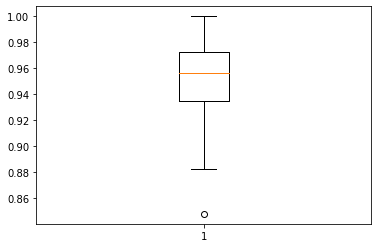

In [17]:
import statistics

print("Mean AUC score:", statistics.mean(auc_scores))
print("Median AUC score:", statistics.median(auc_scores))
print("Standard deviation of AUC scores:", statistics.stdev(auc_scores))

# Create a figure instance
fig = plt.figure()

# Create an axes instance
ax = fig.add_subplot(111)

# Create the boxplot
bp = ax.boxplot(auc_scores)

In [18]:
auc_scores

[0.9504761904761905,
 0.9365384615384615,
 0.9980769230769231,
 0.9365384615384614,
 0.9079999999999999,
 0.8876190476190476,
 0.9538461538461538,
 1.0,
 0.9865384615384616,
 0.98,
 0.921904761904762,
 0.9653846153846154,
 0.95,
 0.9596153846153846,
 0.972,
 0.9904761904761905,
 0.9673076923076923,
 0.9980769230769231,
 0.8999999999999999,
 0.9100000000000001,
 0.9519230769230769,
 0.926923076923077,
 0.9884615384615385,
 0.9295238095238095,
 0.946,
 0.9771428571428571,
 0.9634615384615384,
 0.9365384615384614,
 0.9442307692307693,
 0.952,
 0.9346153846153846,
 0.9192307692307692,
 0.9403846153846154,
 0.980952380952381,
 0.98,
 0.9461538461538462,
 0.9538461538461539,
 0.9403846153846154,
 0.9314285714285714,
 0.984,
 0.937142857142857,
 0.9884615384615385,
 0.9615384615384615,
 0.8826923076923077,
 0.934,
 0.9066666666666667,
 0.9788461538461538,
 0.9442307692307693,
 0.9519230769230769,
 0.9500000000000001,
 0.9096153846153847,
 0.9846153846153846,
 0.9673076923076923,
 0.9771428571

In [19]:
list_of_dicts

[{'iteration': 0, 'fold': 0, 'score': 0.9504761904761905},
 {'iteration': 24, 'fold': 1, 'score': 0.9365384615384615},
 {'iteration': 24, 'fold': 2, 'score': 0.9980769230769231},
 {'iteration': 23, 'fold': 3, 'score': 0.9365384615384614},
 {'iteration': 24, 'fold': 4, 'score': 0.9079999999999999},
 {'iteration': 1, 'fold': 0, 'score': 0.8876190476190476},
 {'iteration': 24, 'fold': 1, 'score': 0.9538461538461538},
 {'iteration': 23, 'fold': 2, 'score': 1.0},
 {'iteration': 24, 'fold': 3, 'score': 0.9865384615384616},
 {'iteration': 24, 'fold': 4, 'score': 0.98},
 {'iteration': 2, 'fold': 0, 'score': 0.921904761904762},
 {'iteration': 23, 'fold': 1, 'score': 0.9653846153846154},
 {'iteration': 24, 'fold': 2, 'score': 0.95},
 {'iteration': 24, 'fold': 3, 'score': 0.9596153846153846},
 {'iteration': 23, 'fold': 4, 'score': 0.972},
 {'iteration': 3, 'fold': 0, 'score': 0.9904761904761905},
 {'iteration': 24, 'fold': 1, 'score': 0.9673076923076923},
 {'iteration': 23, 'fold': 2, 'score': 0.

# Feature Importances

In [20]:
feature_importances_df = pd.DataFrame.from_dict(feature_importances,orient='index')
feature_importances_df['median'] = feature_importances_df.median(axis=1, skipna=True)
feature_importances_df = feature_importances_df.sort_values('median', ascending=False)

feature_importances_df = feature_importances_df.drop(columns = 'median').transpose()
feature_importances_df

/opt/miniconda3/lib/python3.7/site-packages/numpy-1.18.5-py3.7-macosx-10.9-x86_64.egg/numpy/lib/nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


,VOLUME_ET (1mm3voxel),IDH/codel subtype,Mutation Count,MGMT promoter status,Vital status (1=dead),Karnofsky Performance Score,Percent aneuploidy,ParietalLobe,TemporalLobe,VOLUME_WT (1mm3voxel),...,Gender,Thalamus,Caudate,Putamen,Chr 19/20 co-gain,1p/19q codeletion,Study,IDH status,Insula,VOLUME_NET (1mm3voxel)
0,0.138449,0.165788,0.178302,0.102950,0.058154,0.048793,0.033808,0.025516,0.023035,0.013248,...,0.000362,0.0,0.0,0.034098,0.0,0.000000,NaN,NaN,NaN,NaN
1,0.169586,0.166227,0.203526,0.067567,0.047673,0.061141,0.039313,0.029373,0.014616,0.020396,...,0.010093,0.0,0.0,0.007741,0.0,0.002817,NaN,NaN,NaN,NaN
2,0.162729,0.207077,0.139115,0.144204,0.079618,0.042841,0.030918,0.031436,0.029625,0.024137,...,0.000000,0.0,0.0,0.000000,0.0,0.020153,NaN,NaN,NaN,NaN
3,0.278955,0.122934,0.189991,0.063368,0.046576,0.050043,0.027777,0.023662,0.014954,0.011055,...,0.000000,0.0,0.0,0.010575,0.0,0.014574,NaN,NaN,NaN,NaN
4,0.169722,0.188873,0.175981,0.082359,0.085530,0.039238,0.038262,0.029276,0.036674,0.000000,...,0.008899,0.0,0.0,0.000000,0.0,0.000000,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,0.196453,0.184503,0.135985,0.120544,0.066569,0.031352,0.044733,0.034637,0.020978,0.023224,...,0.000000,0.0,0.0,0.007234,0.0,0.000000,NaN,NaN,NaN,NaN
146,0.204400,0.153976,0.172311,0.086813,0.045464,0.043759,0.022804,0.019253,0.016276,0.016090,...,0.000000,0.0,0.0,0.008292,0.0,0.019469,NaN,NaN,NaN,NaN
147,0.148758,0.128946,0.250329,0.120078,0.070160,0.069426,0.043411,0.020305,0.015477,0.013045,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,NaN,NaN,NaN,NaN
148,0.223409,0.180290,0.135298,0.124954,0.059696,0.041048,0.034113,0.025440,0.044198,0.012368,...,0.007937,0.0,0.0,0.000000,0.0,0.000000,NaN,NaN,NaN,NaN


[Text(0, 0, 'VOLUME_ET    (1mm3voxel)'),
 Text(0, 0, 'IDH/codel subtype'),
 Text(0, 0, 'Mutation Count'),
 Text(0, 0, 'MGMT promoter status'),
 Text(0, 0, 'Vital status (1=dead)'),
 Text(0, 0, 'Karnofsky Performance Score'),
 Text(0, 0, 'Percent aneuploidy'),
 Text(0, 0, 'ParietalLobe'),
 Text(0, 0, 'TemporalLobe'),
 Text(0, 0, 'VOLUME_WT      (1mm3voxel)'),
 Text(0, 0, 'VOLUME_ED         (1mm3voxel)'),
 Text(0, 0, 'ABSOLUTE purity'),
 Text(0, 0, 'Cerebellum'),
 Text(0, 0, 'VOLUME_TC         (1mm3voxel)'),
 Text(0, 0, 'Age (years at diagnosis)'),
 Text(0, 0, 'OccipitalLobe'),
 Text(0, 0, 'Survival (months)'),
 Text(0, 0, 'ABSOLUTE ploidy'),
 Text(0, 0, 'Frontal Lobe'),
 Text(0, 0, 'Gender'),
 Text(0, 0, 'Thalamus'),
 Text(0, 0, 'Caudate'),
 Text(0, 0, 'Putamen'),
 Text(0, 0, 'Chr 19/20 co-gain'),
 Text(0, 0, '1p/19q codeletion'),
 Text(0, 0, 'Study'),
 Text(0, 0, 'IDH status'),
 Text(0, 0, 'Insula'),
 Text(0, 0, 'VOLUME_NET         (1mm3voxel)')]

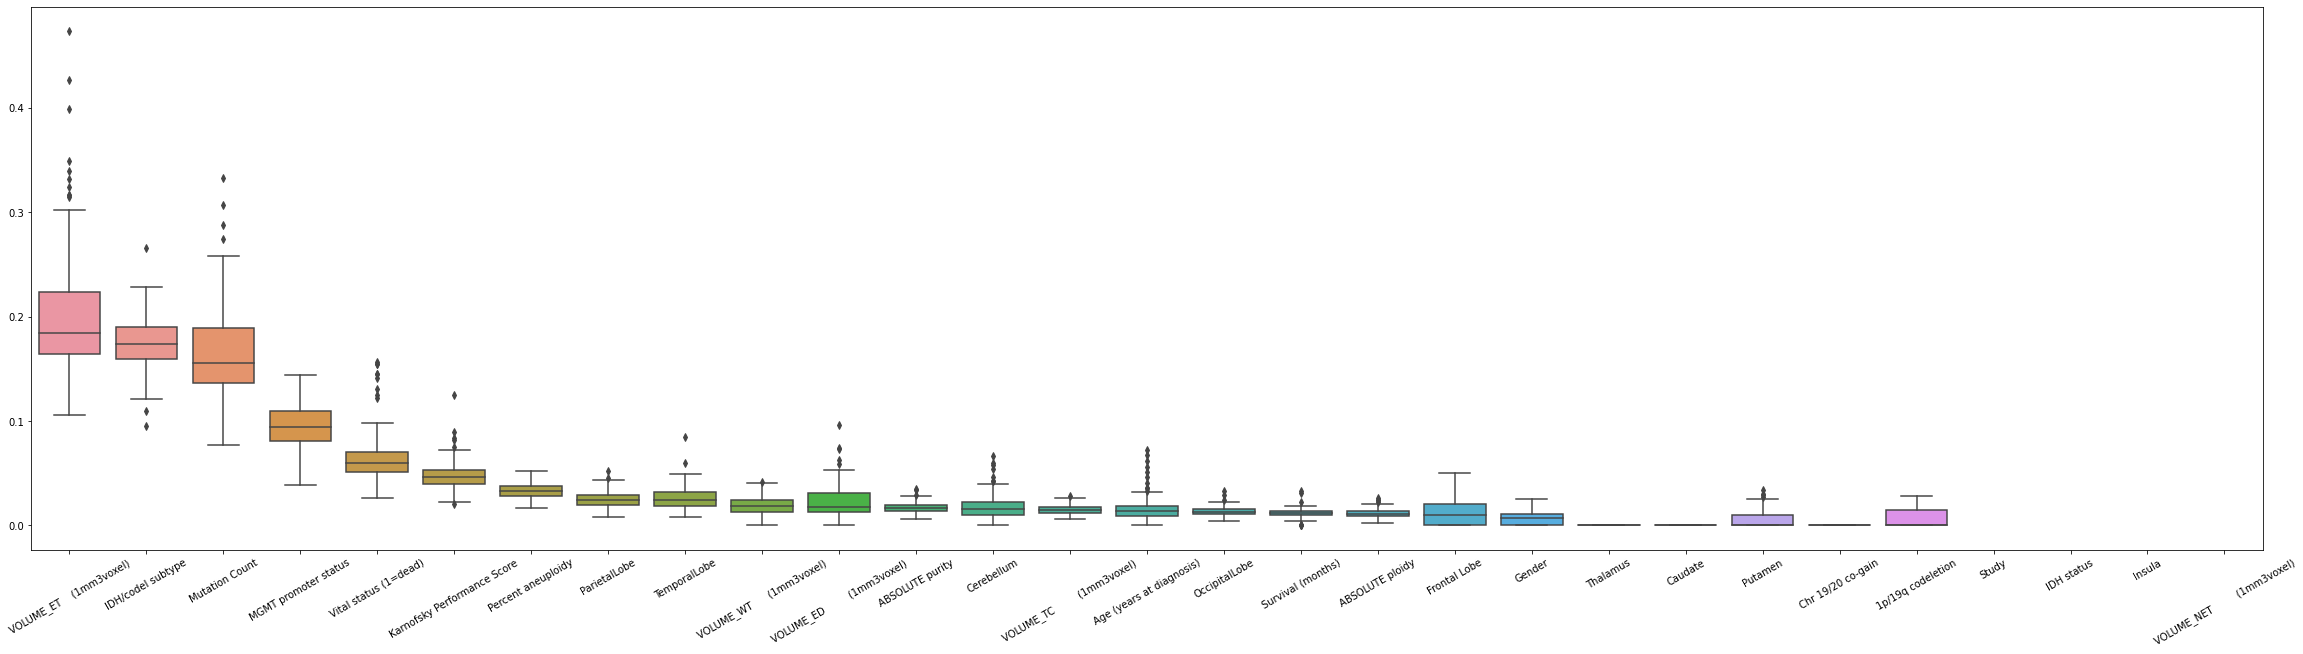

In [21]:
df_to_plot = feature_importances_df.copy()
df_to_plot = df_to_plot.drop(df_to_plot.columns[50:], axis = 1)
plt.figure(figsize=(40,10))
feature_bxplt = sns.boxplot(data=df_to_plot)
feature_bxplt.set_xticklabels(feature_bxplt.get_xticklabels(),rotation=30)